# Cross Validation

In this notebook, I validate choices using cross validation.

In [1]:
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

import aviary as av
import astropy.modeling as apm

from tqdm import trange
import pickle

from cv_routines import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [ ]:
def RMS(ypred, yobs):
    return np.sqrt(sum((ypred - yobs)**2) / float(len(ypred)))

def MAD(ypred, yobs):
    return np.median(abs(ypred - yobs))

Variables to be optimized:

In [ ]:
filename = "../data/CV_gp_model.pkl"

In [ ]:
young_limit = .7  # .1 is worse.
old_limit = 20.
hot_limit = 1.
dp, dc = .05, .05
cluster_old_err = .05  # The relative prot uncertainty on Ruprecht 147 and NGC6819
kinerr = .05 # The relative prot uncertainty on kinematic grid periods. .1 was worse. .03 also worse, but better MAD (bad at old ages).
sun_err = .01  # The absolute prot uncertainty on the Sun's rotation period.

In [ ]:
x, age, prot, prot_err, ID, akin = assemble_data(young_limit, old_limit, hot_limit, dp, dc, cluster_old_err, kinerr, sun_err)

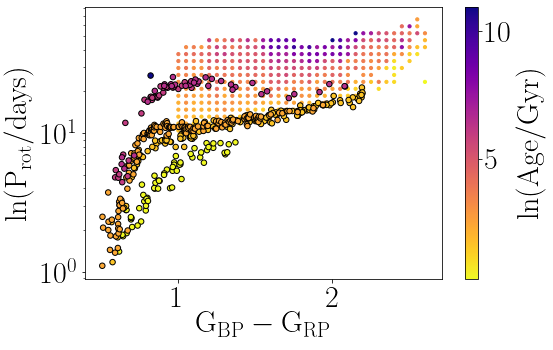

In [7]:
plt.figure(figsize=(8, 5))
plt.scatter(x[ID==0], prot[ID==0], c=age[ID==0], s=30, edgecolor="k", cmap="plasma_r", zorder=1)
plt.scatter(x[ID==1], prot[ID==1], c=age[ID==1], s=10, cmap="plasma_r", zorder=0)
plt.xlabel("$$\mathrm{G_{BP}-G_{RP}}$$")
plt.ylabel("$\mathrm{ln(P_{rot}/days)}$")
plt.colorbar(label="$\mathrm{ln(Age/Gyr)}$")
plt.yscale("log")

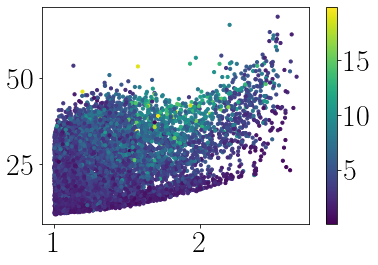

In [8]:
plt.scatter(akin.bprp_dered, akin.Prot, c=akin.kin_age_lucy, s=10)
plt.colorbar();

First, let's see what the age residuals look like when you don't leave any stars out. Fit the model to all the data.

In [9]:
# Fit the GP gyro model
av.fit_gp(x, age, prot, prot_err, filename)

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1129.4124958259379 -> -1125.358688145844
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1125.358688145844 -> -1124.6993266585662
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1124.6993266585662 -> -1122.696830892079
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1122.696830892079 -> -1120.8458250811195
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1120.8458250811195 -> 203.45071065108277
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Desired error not necessarily achieved due to precision loss.
logp: 203.45071065108277 -> 216.34161251220746


done


What age do you infer for each star when you do this?

In [10]:
# def get_stellar_ages(x, prot, prot_err):
#     # Loop over stars.
#     mu, mu_fit, sig = [np.zeros(len(x)) for i in range(3)]
#     for i in trange(len(x)):

#         # Get the age posterior
#         age_array, posterior = ap.get_post(x[i], prot[i], prot_err[i])

#         # Adopt MAP as mean
#         mu[i] = age_array[posterior == max(posterior)]

#         g_init = apm.models.Gaussian1D(amplitude=1., mean=mu[i], stddev=.5)
#         fit_g = apm.fitting.LevMarLSQFitter()
#         g = fit_g(g_init, age_array, posterior)
#         mu_fit[i], sig[i] = g.mean.value, g.stddev.value
#     return mu, sig, mu_fit

# ap = AgePosterior(filename)
mu, sig, mu_fit = get_stellar_ages(x, prot, prot_err, filename)

  0%|          | 0/752 [00:00<?, ?it/s]


NameError: name 'apm' is not defined

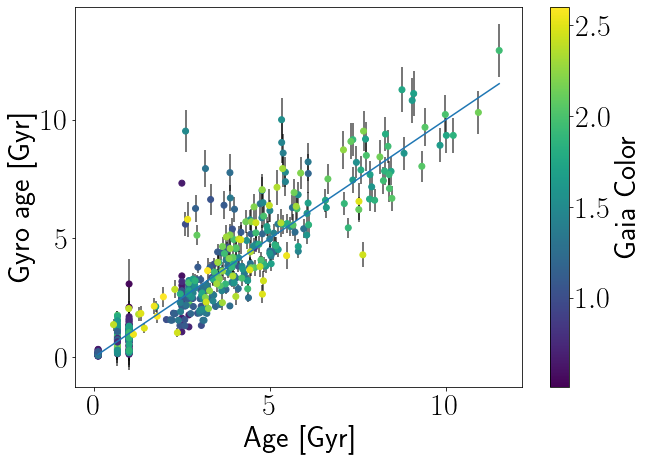

In [63]:
fig = plt.figure(figsize=(10, 7))
# plt.errorbar(age, mu-age, yerr=sig, fmt=".")
# plt.axhline(0, color="k", lw=.5)
plt.errorbar(age, mu, yerr=sig, fmt="k.", alpha=.7, zorder=0)
plt.scatter(age, mu, c=x)
xs = np.linspace(min(age), max(age), 100)
plt.plot(xs, xs)
plt.colorbar(label="Gaia Color")
plt.xlabel("Age [Gyr]")
plt.ylabel("Gyro age [Gyr]");

In [64]:
rms = RMS(age, mu)
mad = MAD(age, mu)
rms, mad

(0.8615543147488822, 0.27549343286255623)

In [31]:
bench_rms, bench_MAD = (0.8408739898745828, 0.3057444738201246)

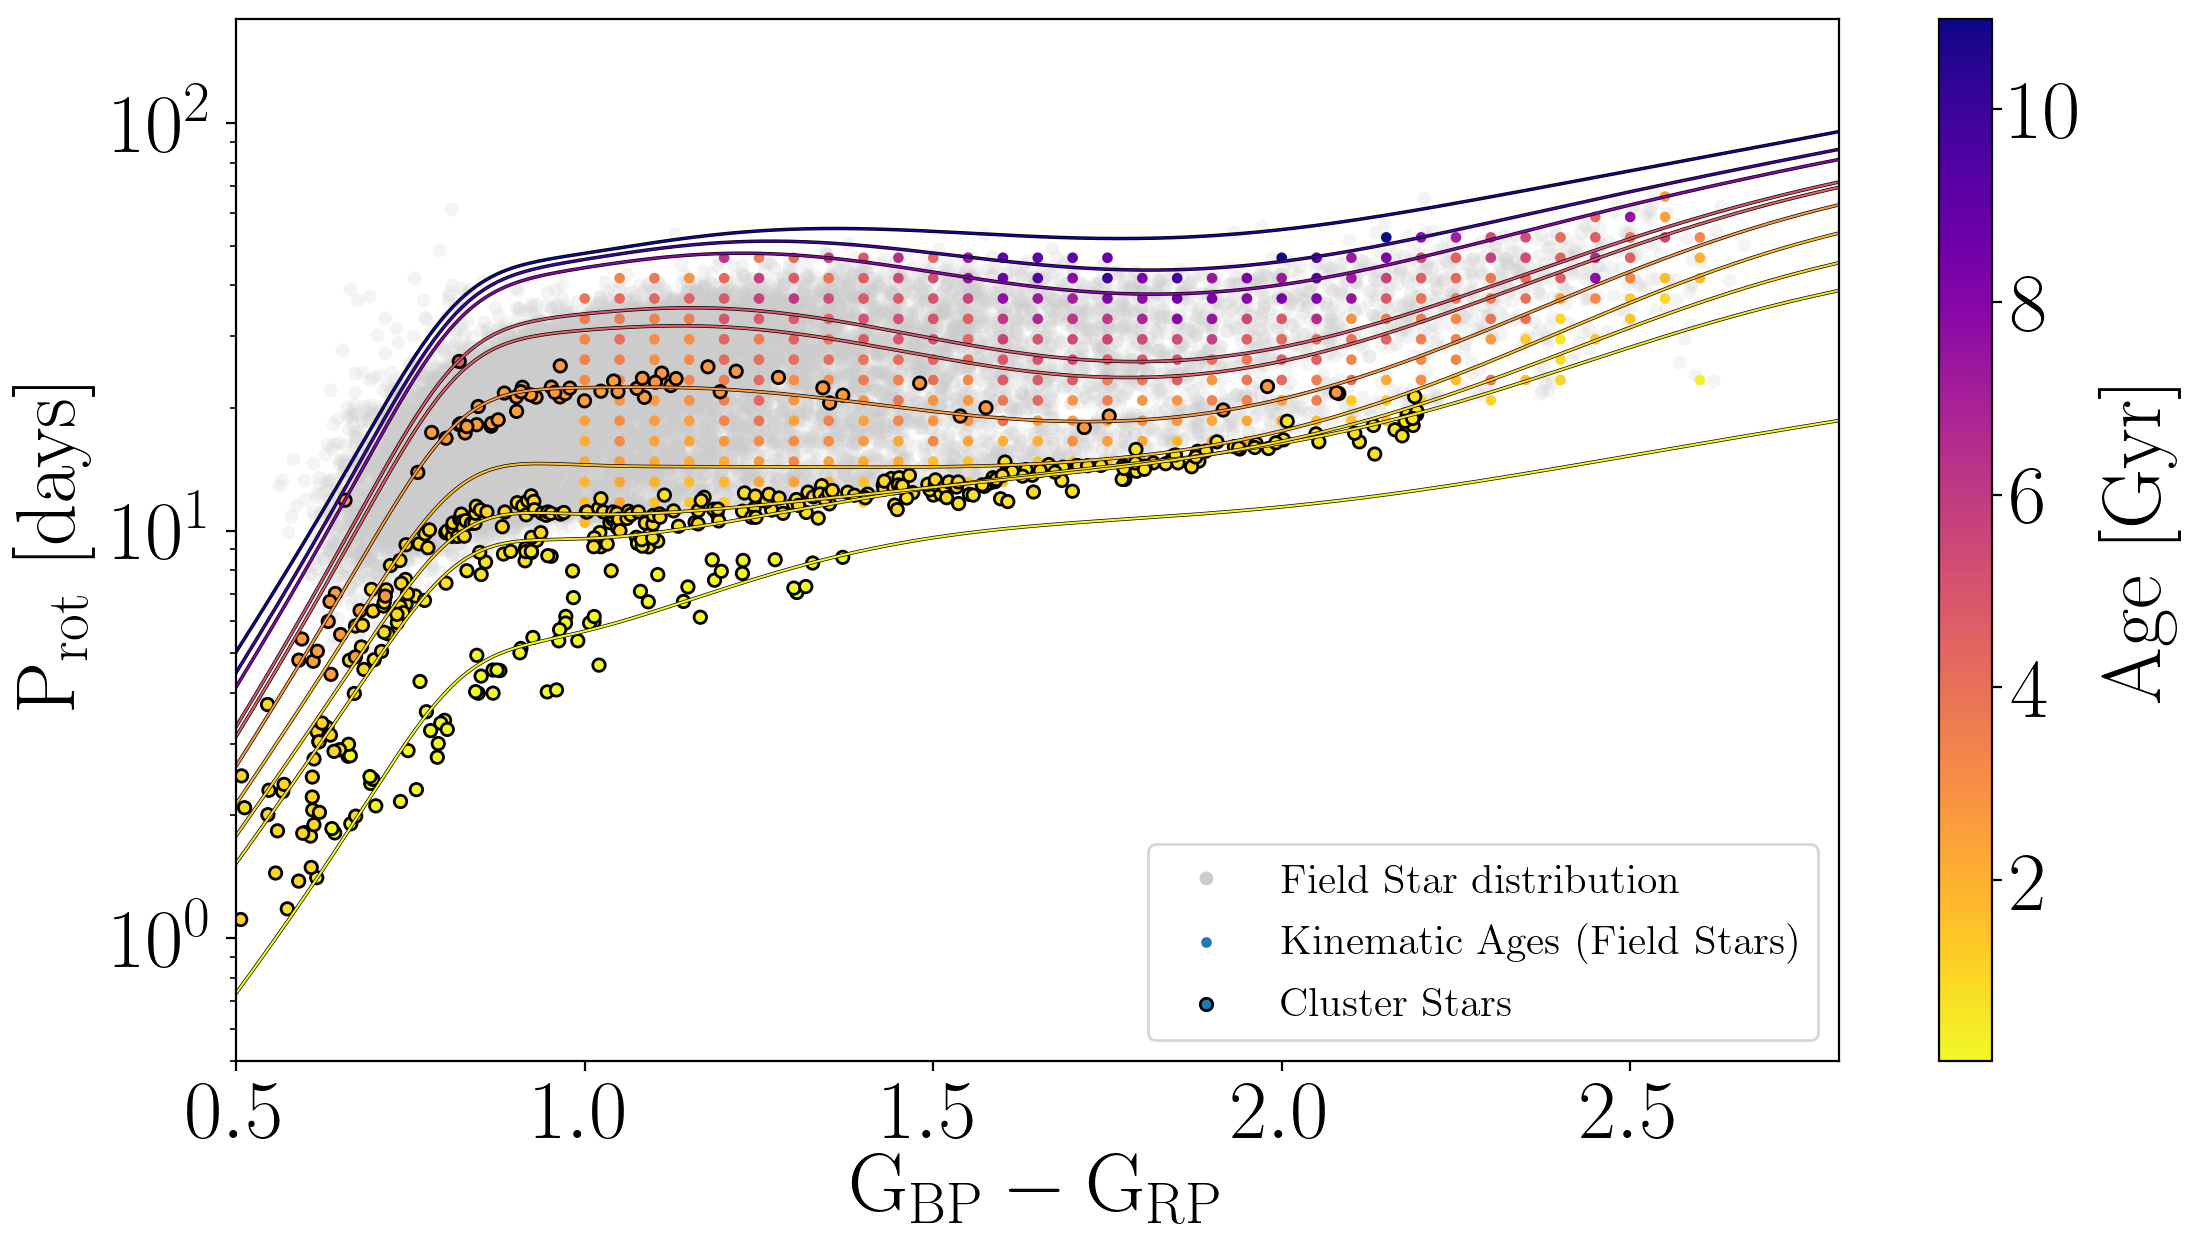

In [13]:
make_plot(kin, x, age, prot, prot_err, cluster_x, cluster_prot, cluster_age, filename)

Pull out some data for cross validation and loop over cross validation batches.

In [142]:
# Pull some cluster data out for cross validation.
np.random.seed(42)
nbatches, nstars = 10, 10
ind_batches = [np.random.choice(np.arange(len(x)), nstars) for i in range(nbatches)]
all_true_ages, all_pred_ages, all_sig, all_ids = [], [], [], []

filename = "../data/CV_gp_model.pkl"
for i in range(nbatches):  # For each cross validation test
    
    # Divide into train and validate
    bools = np.ones(len(x), dtype="bool")
    bools[ind_batches[i]] = np.zeros(len(bools[ind_batches[i]]), dtype="bool")*1
    x_val, prot_val, prot_err_val, age_val, ID_val = x[ind_batches[i]], prot[ind_batches[i]], prot_err[ind_batches[i]], age[ind_batches[i]], ID[ind_batches[i]]
    _x, _prot, _prot_err, _age, _ID = x[bools], prot[bools], prot_err[bools], age[bools], ID[bools]
    
    # Fit the GP gyro model
    av.fit_gp(_x, _age, _prot, _prot_err, filename)
    
    # Load the age posterior model 
    ap = AgePosterior(filename)

    # Fit Gaussians to each star's age posterior
    mu, mu_fit, sig = [np.zeros(len(x_val)) for i in range(3)]
    for i in range(len(x_val)):
        age_array, posterior = ap.get_post(x_val[i], prot_val[i], prot_err_val[i])
#         age_array = np.log(lin_age_array)  # fit gaussian to log age?

        # Get mean and sigma of posterior. Adopt MAP as mu
        mu[i] = age_array[posterior == max(posterior)]

        g_init = apm.models.Gaussian1D(amplitude=1., mean=mu[i], stddev=.5)
        fit_g = apm.fitting.LevMarLSQFitter()
        g = fit_g(g_init, age_array, posterior)
        mu_fit[i], sig[i] = g.mean.value, g.stddev.value
    
    all_true_ages.append(age_val)
#     all_pred_ages.append(np.exp(mu))
    all_pred_ages.append(mu)
    all_sig.append(sig)
    all_ids.append(ID_val)

0
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1115.0109389611189 -> -1110.9771282172117
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.9771282172117 -> -1110.307096853559
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.307096853559 -> -1108.3181376449688
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3181376449688 -> -1106.4659856787441
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4659856787441 -> 200.93390760518426
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 200.93390760518426 -> 213.93208513514344


done
1
752 10
10
10


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9666658110593 -> -1110.924465326862
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.924465326862 -> -1110.2794271037285
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.2794271037285 -> -1108.292003402837
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.292003402837 -> -1106.4669148076982
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4669148076982 -> 197.08028474339505
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 197.08028474339505 -> 209.96912840322128


done
2
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9380639082742 -> -1110.900469097682
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.900469097682 -> -1110.2593322825762
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.2593322825762 -> -1108.2847370645313
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.2847370645313 -> -1106.4331026649782
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4331026649782 -> 197.70477894683148
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 197.70477894683148 -> 210.64436420445074


done


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


3
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.8236075967523 -> -1110.8103143782118
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.8103143782118 -> -1110.1599331101227
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.1599331101227 -> -1108.1386373111404
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.1386373111404 -> -1106.299224250222
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.299224250222 -> 205.13568341084505
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Desired error not necessarily achieved due to precision loss.
logp: 205.13568341084505 -> 218.29752477009308


done
4
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9908084771737 -> -1110.9560425864113
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.9560425864113 -> -1110.290383202108
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.290383202108 -> -1108.3102587696526
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3102587696526 -> -1106.4691914189093
INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4691914189093 -> 198.717040019488
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 198.717040019488 -> 211.67057227135024


done
5
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9865098961805 -> -1110.9614543510745
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.9614543510745 -> -1110.305162000496
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.305162000496 -> -1108.3161407937428
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3161407937428 -> -1106.4819535807137
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4819535807137 -> 197.9361720035526
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 197.9361720035526 -> 210.84022129227307


done
6
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


message: Optimization terminated successfully.
logp: -1114.8698423884275 -> -1110.8199589985063
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.8199589985063 -> -1110.1943895626337
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.1943895626337 -> -1108.1842581327621
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.1842581327621 -> -1106.3661302099715
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.3661302099715 -> 201.42807082935053
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 201.42807082935053 -> 213.94109422209598


done
7
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.8923078540536 -> -1110.8626187498046
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.8626187498046 -> -1110.2321695006171
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.2321695006171 -> -1108.2255603346582
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.2255603346582 -> -1106.4076114384236
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4076114384236 -> 208.6414955858067
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 208.6414955858067 -> 222.0980589238796


done
8
752 10
10
10


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9646017338007 -> -1110.957659950133
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.957659950133 -> -1110.3119533382069
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.3119533382066 -> -1108.3224367359
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3224367359 -> -1106.4988038796944
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4988038796944 -> 199.0364951537459
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 199.0364951537459 -> 212.0158693424246


done
9
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.8394675122229 -> -1110.727003662892
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.727003662892 -> -1110.0376581341795
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.0376581341795 -> -1108.1315030410356
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.1315030410356 -> -1106.3258382968966
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.3258382968966 -> 198.48500393088358
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 198.48500393088358 -> 212.29104858502794


done


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


Combine results from all batches.

In [143]:
ata = np.array([i for j in all_true_ages for i in j])
apa = np.array([i for j in all_pred_ages for i in j])
asig = np.array([i for j in all_sig for i in j])
ai = np.array([i for j in all_ids for i in j])

1.098236367174673


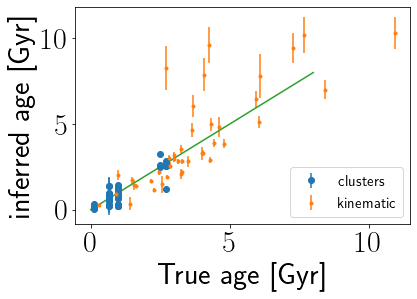

In [144]:
# Plot inferred vs. true age
plt.errorbar(ata[ai==0], apa[ai==0], yerr=asig[ai==0], fmt="o", label="clusters")
plt.errorbar(ata[ai==1], apa[ai==1], yerr=asig[ai==1], fmt=".", label="kinematic")
xs = np.linspace(0, 8, 100)
plt.plot(xs, xs)
plt.xlabel("True age [Gyr]")
plt.ylabel("inferred age [Gyr]")
plt.legend()
print(RMS(ata, apa))

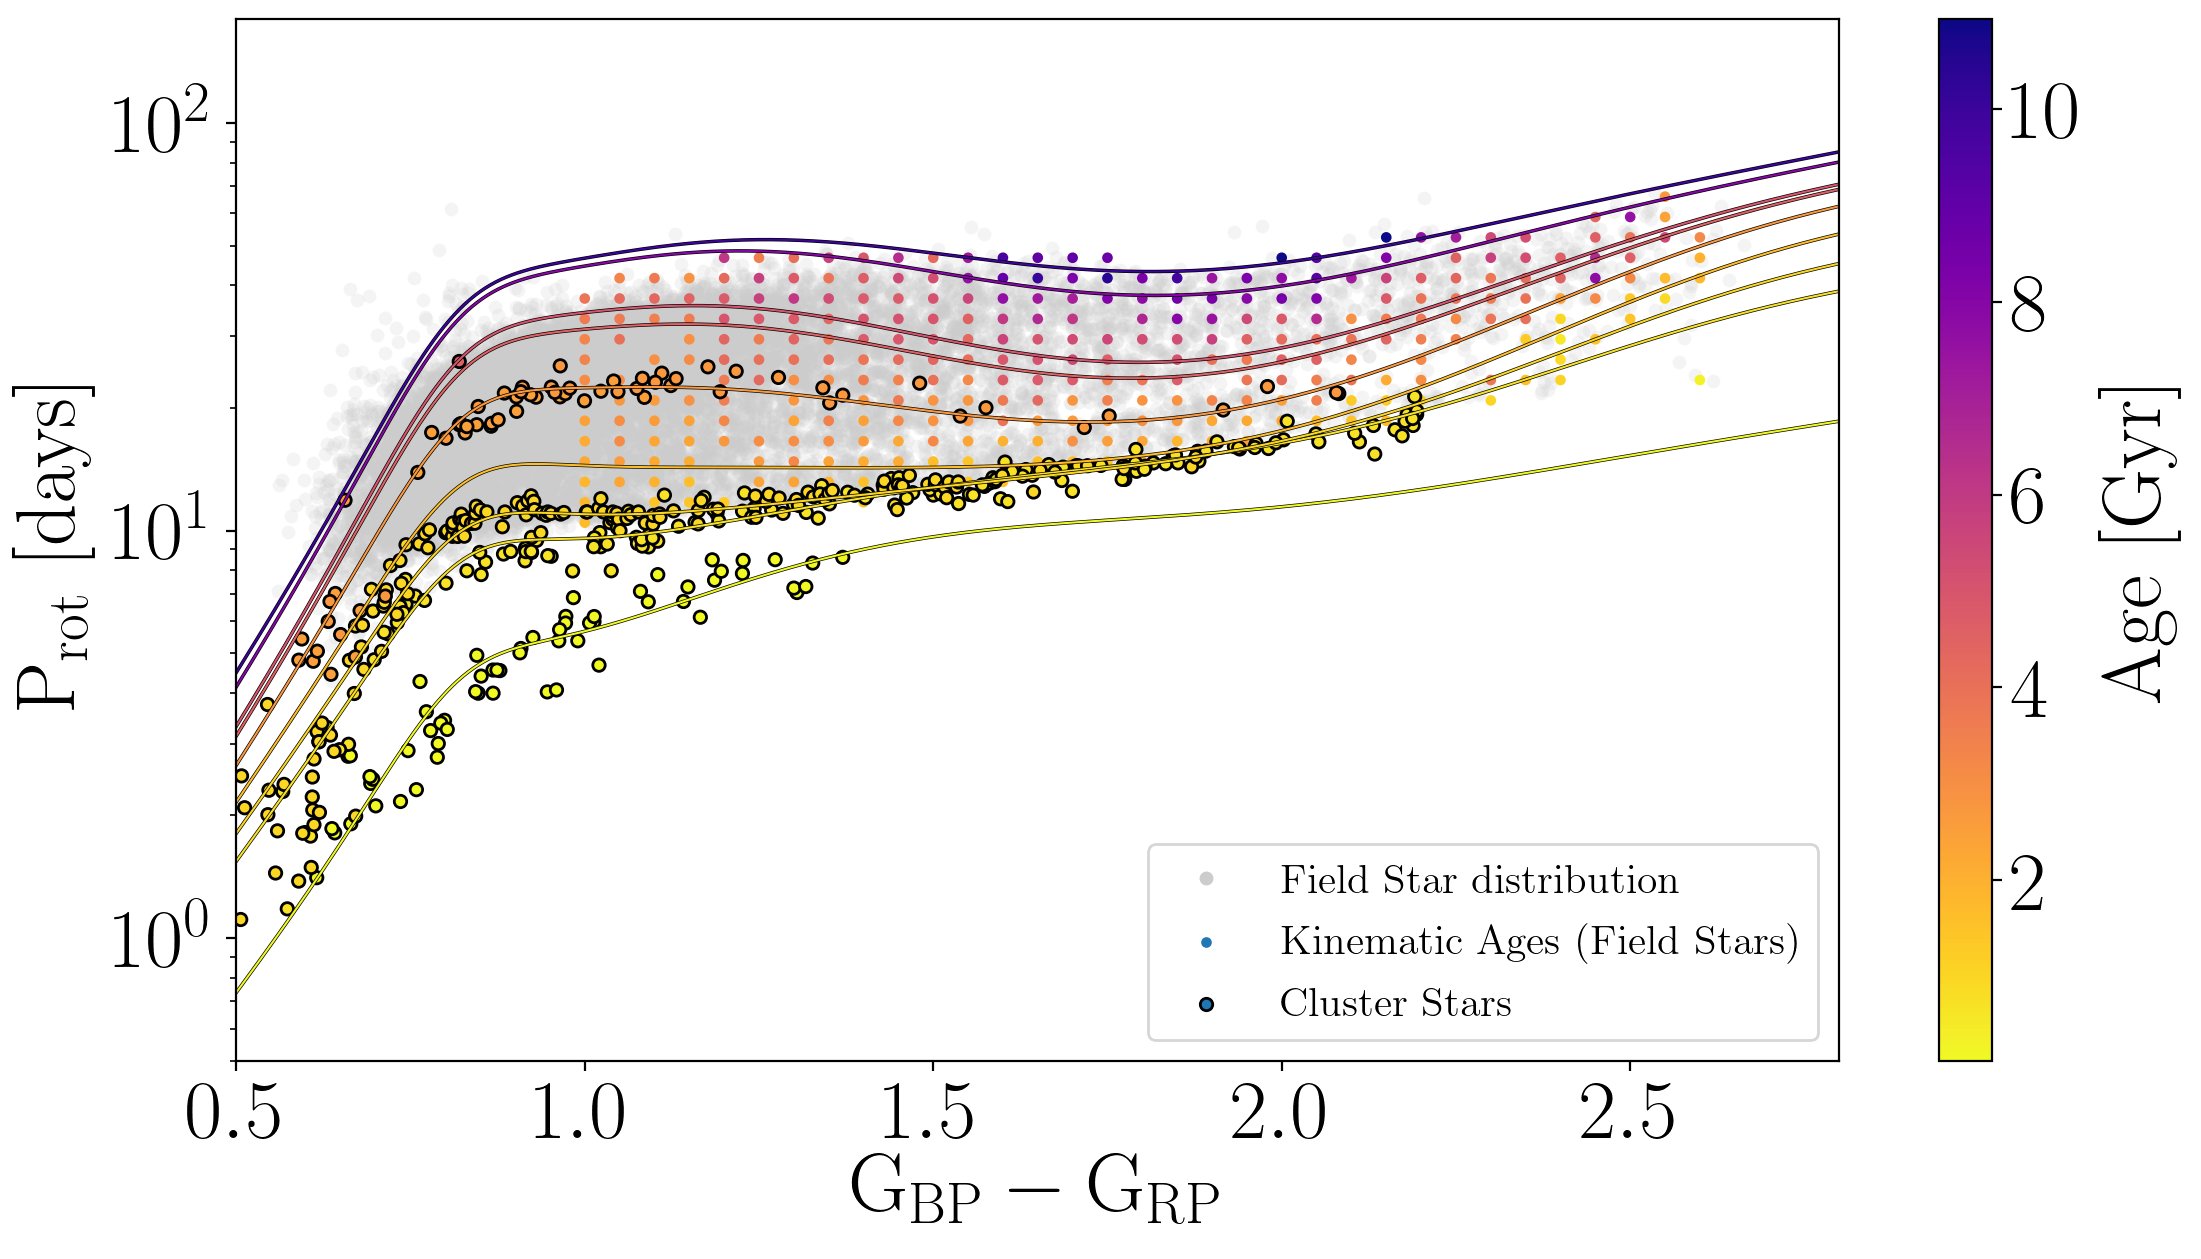

In [69]:
make_plot()